In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [2]:
# 1. Load and preprocess data
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')
day_columns = [col for col in sales_train_validation.columns if col.startswith('d_')]
sales_data = sales_train_validation[['item_id', 'store_id', 'state_id'] + day_columns]


In [3]:
# Filter for non-zero sales
sales_data['total_sales'] = sales_data[day_columns].sum(axis=1)
active_sales = sales_data[sales_data['total_sales'] > 0].copy()

C:\Users\KIIT\AppData\Local\Temp\ipykernel_7292\3474476187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data['total_sales'] = sales_data[day_columns].sum(axis=1)


In [4]:
# Select 2-3 items for Ridge Regression (top-selling items)
top_items = active_sales.groupby('item_id')['total_sales'].sum().nlargest(3).index.tolist()
selected_items = top_items[:3]  # e.g., ['FOODS_3_090', 'HOBBIES_1_008', 'HOUSEHOLD_1_001']
print(f"Selected items for Ridge Regression: {selected_items}")

Selected items for Ridge Regression: ['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252']


In [5]:
# 2. Create hierarchical aggregates
# Item-store level
item_store_sales = active_sales[['item_id', 'store_id', 'state_id'] + day_columns].copy()
item_store_sales['level'] = item_store_sales['item_id'] + '_' + item_store_sales['store_id']

# Store level
store_sales = active_sales.groupby('store_id')[day_columns].sum().reset_index()
store_sales['level'] = store_sales['store_id']

# State level
state_sales = active_sales.groupby('state_id')[day_columns].sum().reset_index()
state_sales['level'] = state_sales['state_id']

# Total level
total_sales = active_sales[day_columns].sum().reset_index()
total_sales.columns = ['day', 'sales']
total_sales['level'] = 'total'

In [6]:
# 3. ARIMA Forecasting
def fit_arima(series, order=(1,1,1)):
    try:
        model = ARIMA(series, order=order)
        fit = model.fit()
        forecast = fit.forecast(steps=365)
        return forecast
    except:
        return np.zeros(365)  # Fallback to zero forecast if ARIMA fails

# Apply ARIMA to all levels
arima_forecasts = []

# Item-store level
for _, row in item_store_sales[['level'] + day_columns].iterrows():
    series = row[day_columns].values
    forecast = fit_arima(series)
    arima_forecasts.append({'level': row['level'], 'forecast': forecast, 'type': 'item_store'})

# Store level
for _, row in store_sales[['level'] + day_columns].iterrows():
    series = row[day_columns].values
    forecast = fit_arima(series)
    arima_forecasts.append({'level': row['level'], 'forecast': forecast, 'type': 'store'})

# State level
for _, row in state_sales[['level'] + day_columns].iterrows():
    series = row[day_columns].values
    forecast = fit_arima(series)
    arima_forecasts.append({'level': row['level'], 'forecast': forecast, 'type': 'state'})

# Total level
series = total_sales['sales'].values
forecast = fit_arima(series)
arima_forecasts.append({'level': 'total', 'forecast': forecast, 'type': 'total'})

arima_forecasts_df = pd.DataFrame([
    {'level': f['level'], 'type': f['type'], 'arima_forecast': f['forecast'].sum()}
    for f in arima_forecasts
])

# Bottom-up reconciliation for ARIMA
item_store_arima = arima_forecasts_df[arima_forecasts_df['type'] == 'item_store'].copy()
item_store_arima[['item_id', 'store_id']] = item_store_arima['level'].str.split('_', expand=True)[[0, 1]]
store_arima_bu = item_store_arima.groupby('store_id')['arima_forecast'].sum().reset_index(name='arima_bu_forecast').rename(columns={'store_id': 'level'})
state_arima_bu = item_store_arima.merge(active_sales[['store_id', 'state_id']].drop_duplicates(), on='store_id').groupby('state_id')['arima_forecast'].sum().reset_index(name='arima_bu_forecast').rename(columns={'state_id': 'level'})
total_arima_bu = pd.DataFrame([{'level': 'total', 'arima_bu_forecast': item_store_arima['arima_forecast'].sum()}])

arima_forecasts_df = arima_forecasts_df.merge(store_arima_bu, on='level', how='left').merge(
    state_arima_bu, on='level', how='left').merge(total_arima_bu, on='level', how='left')

In [7]:
# 4. Subset Ridge Regression for selected items
# Prepare data for Ridge Regression
ridge_data = item_store_sales[item_store_sales['item_id'].isin(selected_items)].melt(
    id_vars=['item_id', 'store_id', 'level'], 
    value_vars=day_columns, 
    var_name='day', 
    value_name='sales'
)
ridge_data['day_num'] = ridge_data['day'].str.extract(r'(\d+)').astype(int)

In [8]:
# Add time series features
ridge_data['lag_1'] = ridge_data.groupby('level')['sales'].shift(1)
ridge_data['lag_7'] = ridge_data.groupby('level')['sales'].shift(7)
ridge_data['day_of_week'] = (ridge_data['day_num'] % 7).astype(int)
ridge_data = ridge_data.dropna()

# Train Ridge Regression model for each item-store combination
ridge_forecasts = []
scaler = StandardScaler()

for level in ridge_data['level'].unique():
    level_data = ridge_data[ridge_data['level'] == level]
    X = level_data[['day_num', 'lag_1', 'lag_7', 'day_of_week']]
    y = level_data['sales']
    X_scaled = scaler.fit_transform(X)
    
    model = Ridge(alpha=1.0)
    model.fit(X_scaled, y)
    
    # Forecast for 365 days
    forecast = []
    last_data = level_data.tail(1)
    last_day = last_data['day_num'].iloc[0]
    last_lag_1 = last_data['sales'].iloc[0]
    last_lag_7 = last_data['lag_1'].iloc[0] if last_data['lag_1'].iloc[0] is not None else 0
    last_day_of_week = last_data['day_of_week'].iloc[0]
    
    for day in range(1, 366):
        X_pred = np.array([[last_day + day, last_lag_1, last_lag_7, (last_day_of_week + day) % 7]])
        X_pred_scaled = scaler.transform(X_pred)
        pred = model.predict(X_pred_scaled)[0]
        pred = max(pred, 0)  # Ensure non-negative sales
        forecast.append(pred)
        last_lag_1 = pred
        last_lag_7 = pred if day >= 7 else last_lag_7
    
    ridge_forecasts.append({'level': level, 'ridge_forecast': sum(forecast)})

ridge_forecasts_df = pd.DataFrame(ridge_forecasts)


C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature

In [9]:
# 5. Validation (use last 28 days as hold-out)
validation_days = day_columns[-28:]
item_store_valid = item_store_sales[['level'] + validation_days].melt(
    id_vars=['level'], value_vars=validation_days, var_name='day', value_name='actual_sales'
)

# Re-run ARIMA and Ridge for validation
arima_valid_forecasts = []
for level in item_store_sales['level'].unique():
    series = item_store_sales[item_store_sales['level'] == level][day_columns[:-28]].values[0]
    forecast = fit_arima(series, order=(1,1,1))[:28]
    for i, day in enumerate(validation_days):
        arima_valid_forecasts.append({'level': level, 'day': day, 'arima_forecast': forecast[i]})
arima_valid_df = pd.DataFrame(arima_valid_forecasts)

ridge_valid_forecasts = []
for level in ridge_data['level'].unique():
    level_data = ridge_data[ridge_data['level'] == level]
    train_data = level_data[level_data['day'].isin(day_columns[:-28])]
    X_train = train_data[['day_num', 'lag_1', 'lag_7', 'day_of_week']]
    y_train = train_data['sales']
    X_scaled = scaler.fit_transform(X_train)
    model = Ridge(alpha=1.0)
    model.fit(X_scaled, y_train)
    
    test_data = level_data[level_data['day'].isin(validation_days)]
    X_test = test_data[['day_num', 'lag_1', 'lag_7', 'day_of_week']]
    X_test_scaled = scaler.transform(X_test)
    preds = model.predict(X_test_scaled)
    preds = np.maximum(preds, 0)
    
    for i, day in enumerate(validation_days):
        ridge_valid_forecasts.append({'level': level, 'day': day, 'ridge_forecast': preds[i]})
ridge_valid_df = pd.DataFrame(ridge_valid_forecasts)

C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\

In [10]:
# Compute RMSE
arima_valid_rmse = arima_valid_df.merge(item_store_valid, on=['level', 'day']).groupby('level').apply(
    lambda x: np.sqrt(mean_squared_error(x['actual_sales'], x['arima_forecast']))
).reset_index(name='arima_rmse')

ridge_valid_rmse = ridge_valid_df.merge(item_store_valid, on=['level', 'day']).groupby('level').apply(
    lambda x: np.sqrt(mean_squared_error(x['actual_sales'], x['ridge_forecast']))
).reset_index(name='ridge_rmse')

print("\nValidation RMSE (Last 28 Days):")
print(pd.merge(arima_valid_rmse, ridge_valid_rmse, on='level', how='outer').head())


Validation RMSE (Last 28 Days):
              level  arima_rmse  ridge_rmse
0  FOODS_1_001_CA_1    1.307572         NaN
1  FOODS_1_001_CA_2    2.720435         NaN
2  FOODS_1_001_CA_3    2.515247         NaN
3  FOODS_1_001_CA_4    0.600499         NaN
4  FOODS_1_001_TX_1    0.611437         NaN


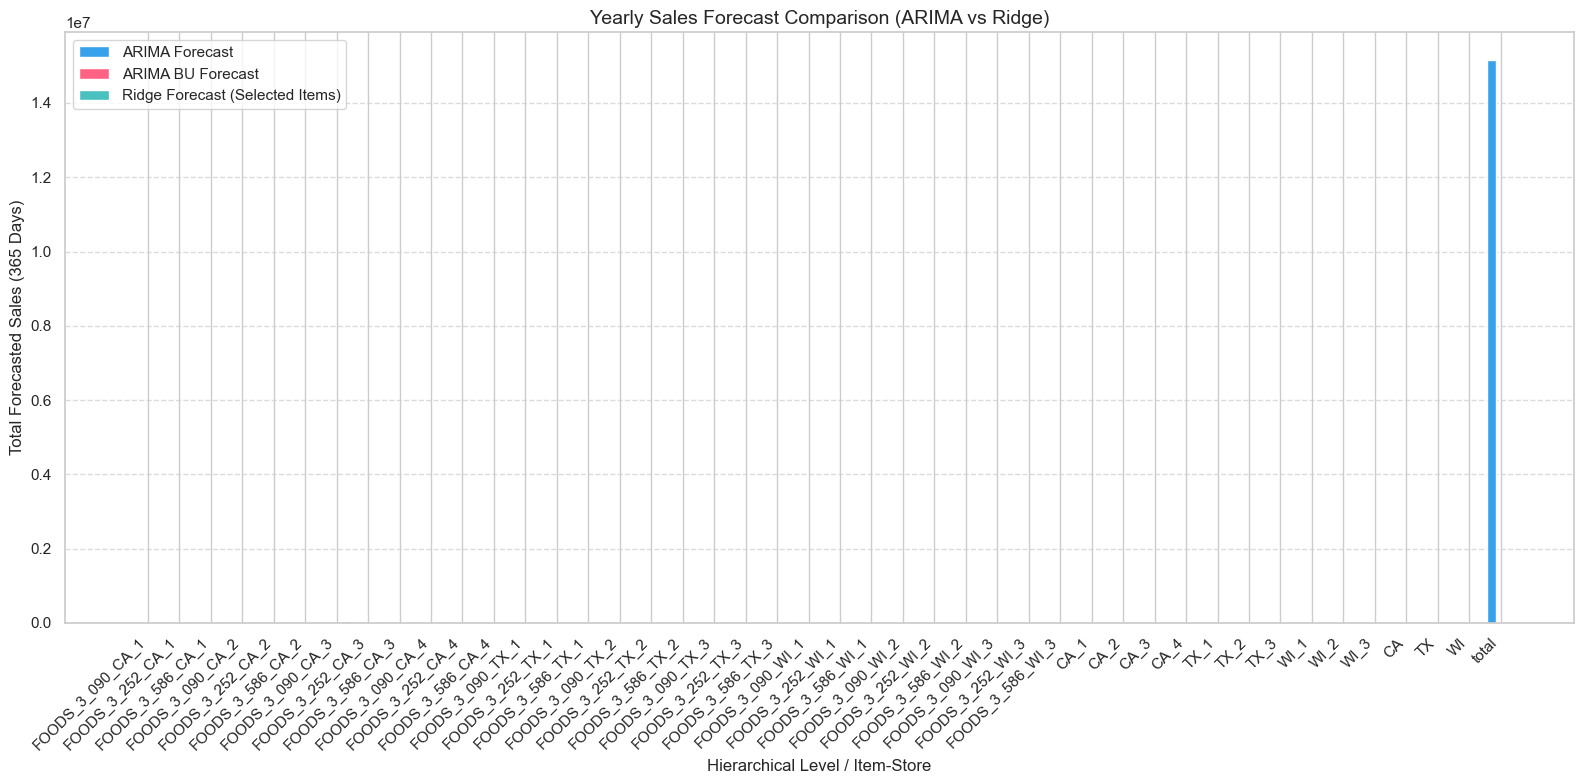

In [11]:
# 6. Visualization
# Prepare data for bar graph
plot_levels = ['total', 'CA', 'TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'] + ridge_forecasts_df['level'].tolist()
plot_df = arima_forecasts_df[arima_forecasts_df['level'].isin(plot_levels)][['level', 'arima_forecast', 'arima_bu_forecast']].copy()
plot_df = plot_df.merge(ridge_forecasts_df[['level', 'ridge_forecast']], on='level', how='left')

# Create bar graph
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.3
index = np.arange(len(plot_df))

bars1 = ax.bar(index, plot_df['arima_forecast'], bar_width, label='ARIMA Forecast', color='#36A2EB')
bars2 = ax.bar(index + bar_width, plot_df['arima_bu_forecast'], bar_width, label='ARIMA BU Forecast', color='#FF6384')
bars3 = ax.bar(index + 2 * bar_width, plot_df['ridge_forecast'], bar_width, label='Ridge Forecast (Selected Items)', color='#4BC0C0')

ax.set_xlabel('Hierarchical Level / Item-Store', fontsize=12)
ax.set_ylabel('Total Forecasted Sales (365 Days)', fontsize=12)
ax.set_title('Yearly Sales Forecast Comparison (ARIMA vs Ridge)', fontsize=14)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(plot_df['level'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('yearly_forecast_comparison.png')
plt.show()

C:\Users\KIIT\AppData\Local\Temp\ipykernel_7292\4089865320.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data['total_sales'] = sales_data[day_columns].sum(axis=1)


Selected items for Ridge Regression: ['HOUSEHOLD_1_001', 'FOODS_3_090', 'HOBBIES_1_008']


C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature


Validation RMSE (Last 28 Days for Selected Items):
                   level  arima_rmse  ridge_rmse
0       FOODS_3_090_CA_1   27.684124   22.766367
1       FOODS_3_090_CA_2   22.927433   16.042351
2       FOODS_3_090_CA_3   46.482884   35.809939
3       FOODS_3_090_CA_4   18.143318   13.158493
4       FOODS_3_090_TX_1   22.154753   14.728245
5       FOODS_3_090_TX_2   36.959758   22.054647
6       FOODS_3_090_TX_3   22.821578   17.694829
7       FOODS_3_090_WI_1   10.390195    9.612468
8       FOODS_3_090_WI_2   13.048693   13.660672
9       FOODS_3_090_WI_3   41.447827   30.816402
10    HOBBIES_1_008_CA_1   10.241185   10.263891
11    HOBBIES_1_008_CA_2    3.216973    3.236548
12    HOBBIES_1_008_CA_3    7.423946    7.441598
13    HOBBIES_1_008_CA_4    3.583993    3.583791
14    HOBBIES_1_008_TX_1    4.367733    4.369862
15    HOBBIES_1_008_TX_2    5.076567    6.429609
16    HOBBIES_1_008_TX_3    3.045975    3.181302
17    HOBBIES_1_008_WI_1    4.043766    3.947242
18    HOBBIES_1_0

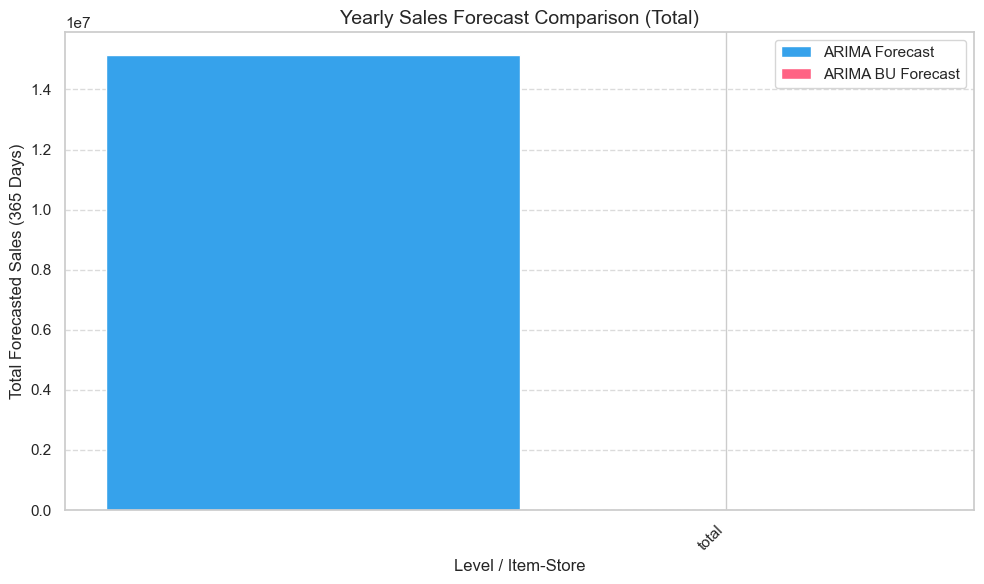

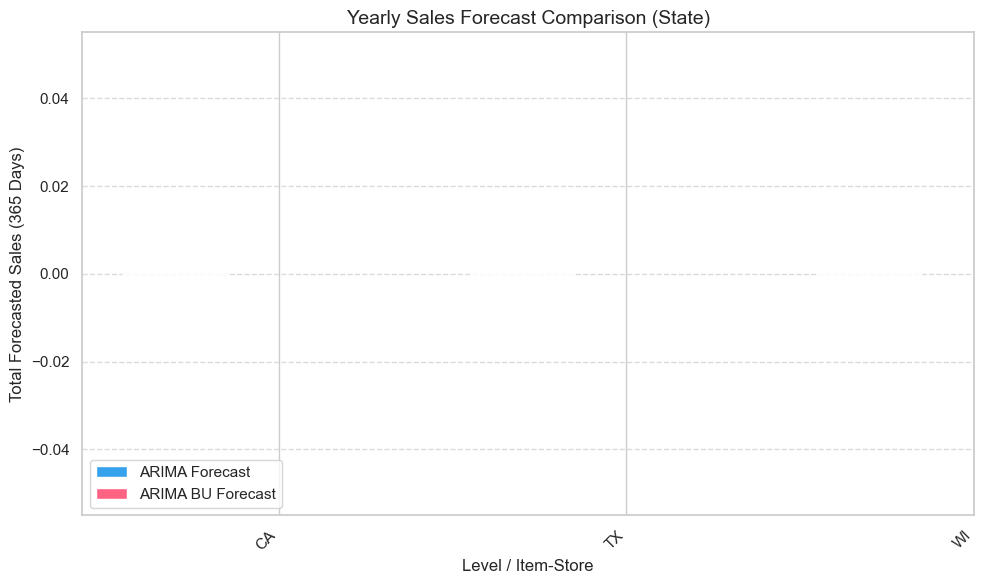

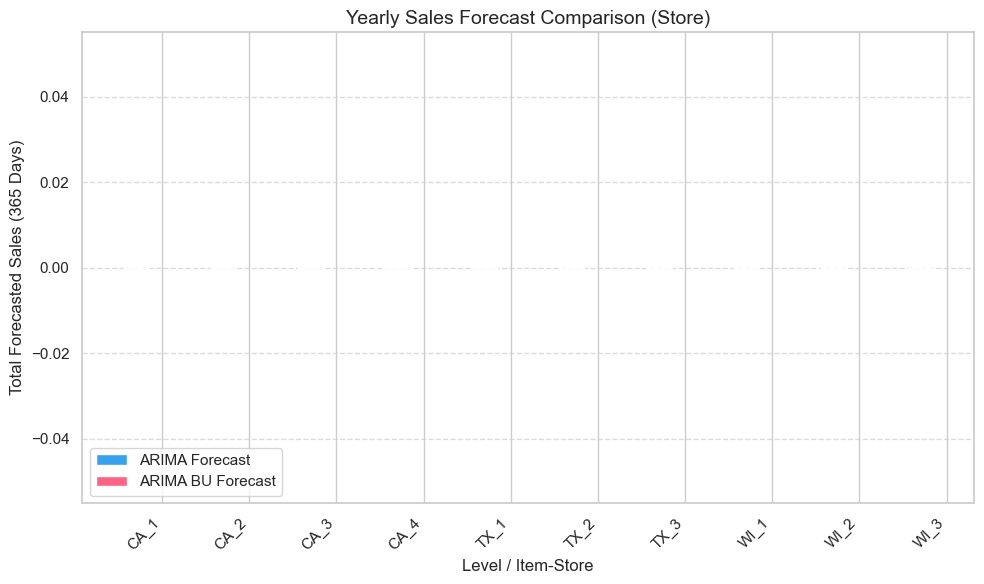

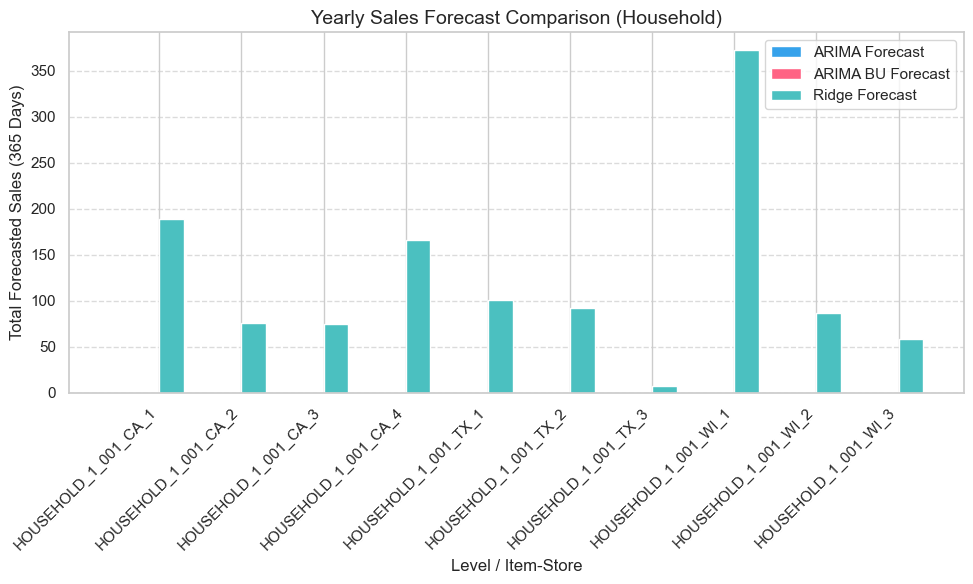

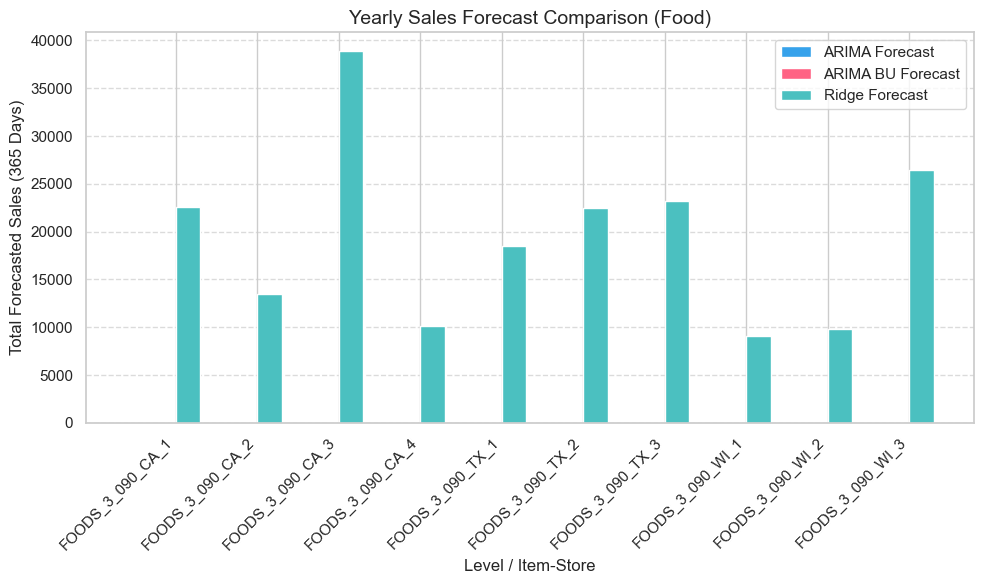

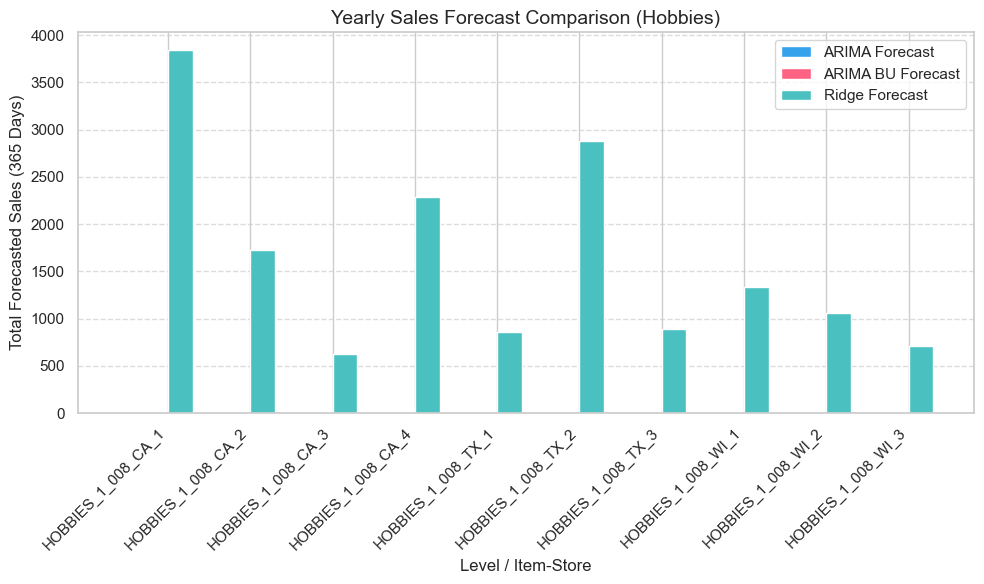

In [12]:

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# 1. Load and preprocess data
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')
day_columns = [col for col in sales_train_validation.columns if col.startswith('d_')]
sales_data = sales_train_validation[['item_id', 'store_id', 'state_id'] + day_columns]

# Filter for non-zero sales
sales_data['total_sales'] = sales_data[day_columns].sum(axis=1)
active_sales = sales_data[sales_data['total_sales'] > 0].copy()

# Select specific lower-level products
selected_items = ['HOUSEHOLD_1_001', 'FOODS_3_090', 'HOBBIES_1_008']
print(f"Selected items for Ridge Regression: {selected_items}")

# 2. Create hierarchical aggregates
# Item-store level
item_store_sales = active_sales[['item_id', 'store_id', 'state_id'] + day_columns].copy()
item_store_sales['level'] = item_store_sales['item_id'] + '_' + item_store_sales['store_id']

# Store level
store_sales = active_sales.groupby('store_id')[day_columns].sum().reset_index()
store_sales['level'] = store_sales['store_id']

# State level
state_sales = active_sales.groupby('state_id')[day_columns].sum().reset_index()
state_sales['level'] = state_sales['state_id']

# Total level
total_sales = active_sales[day_columns].sum().reset_index()
total_sales.columns = ['day', 'sales']
total_sales['level'] = 'total'

# 3. ARIMA Forecasting
def fit_arima(series, order=(1,1,1)):
    try:
        model = ARIMA(series, order=order)
        fit = model.fit()
        forecast = fit.forecast(steps=365)
        return forecast
    except:
        return np.zeros(365)  # Fallback to zero forecast if ARIMA fails

# Apply ARIMA to all levels
arima_forecasts = []

# Item-store level (only for selected items and all for bottom-up)
for _, row in item_store_sales[item_store_sales['item_id'].isin(selected_items + list(active_sales['item_id'].unique()))][['level'] + day_columns].iterrows():
    series = row[day_columns].values
    forecast = fit_arima(series)
    arima_forecasts.append({'level': row['level'], 'forecast': forecast, 'type': 'item_store'})

# Store level
for _, row in store_sales[['level'] + day_columns].iterrows():
    series = row[day_columns].values
    forecast = fit_arima(series)
    arima_forecasts.append({'level': row['level'], 'forecast': forecast, 'type': 'store'})

# State level
for _, row in state_sales[['level'] + day_columns].iterrows():
    series = row[day_columns].values
    forecast = fit_arima(series)
    arima_forecasts.append({'level': row['level'], 'forecast': forecast, 'type': 'state'})

# Total level
series = total_sales['sales'].values
forecast = fit_arima(series)
arima_forecasts.append({'level': 'total', 'forecast': forecast, 'type': 'total'})

arima_forecasts_df = pd.DataFrame([
    {'level': f['level'], 'type': f['type'], 'arima_forecast': f['forecast'].sum()}
    for f in arima_forecasts
])

# Bottom-up reconciliation for ARIMA
item_store_arima = arima_forecasts_df[arima_forecasts_df['type'] == 'item_store'].copy()
item_store_arima[['item_id', 'store_id']] = item_store_arima['level'].str.split('_', expand=True)[[0, 1]]
store_arima_bu = item_store_arima.groupby('store_id')['arima_forecast'].sum().reset_index(name='arima_bu_forecast').rename(columns={'store_id': 'level'})
state_arima_bu = item_store_arima.merge(active_sales[['store_id', 'state_id']].drop_duplicates(), on='store_id').groupby('state_id')['arima_forecast'].sum().reset_index(name='arima_bu_forecast').rename(columns={'state_id': 'level'})
total_arima_bu = pd.DataFrame([{'level': 'total', 'arima_bu_forecast': item_store_arima['arima_forecast'].sum()}])

arima_forecasts_df = arima_forecasts_df.merge(store_arima_bu, on='level', how='left').merge(
    state_arima_bu, on='level', how='left').merge(total_arima_bu, on='level', how='left')

# 4. Subset Ridge Regression for selected items
ridge_data = item_store_sales[item_store_sales['item_id'].isin(selected_items)].melt(
    id_vars=['item_id', 'store_id', 'level'], 
    value_vars=day_columns, 
    var_name='day', 
    value_name='sales'
)
ridge_data['day_num'] = ridge_data['day'].str.extract(r'(\d+)').astype(int)

# Add time series features
ridge_data['lag_1'] = ridge_data.groupby('level')['sales'].shift(1)
ridge_data['lag_7'] = ridge_data.groupby('level')['sales'].shift(7)
ridge_data['day_of_week'] = (ridge_data['day_num'] % 7).astype(int)
ridge_data = ridge_data.dropna()

# Train Ridge Regression model for each item-store combination
ridge_forecasts = []
scaler = StandardScaler()

for level in ridge_data['level'].unique():
    level_data = ridge_data[ridge_data['level'] == level]
    X = level_data[['day_num', 'lag_1', 'lag_7', 'day_of_week']]
    y = level_data['sales']
    X_scaled = scaler.fit_transform(X)
    
    model = Ridge(alpha=1.0)
    model.fit(X_scaled, y)
    
    # Forecast for 365 days
    forecast = []
    last_data = level_data.tail(1)
    last_day = last_data['day_num'].iloc[0]
    last_lag_1 = last_data['sales'].iloc[0]
    last_lag_7 = last_data['lag_1'].iloc[0] if last_data['lag_1'].iloc[0] is not None else 0
    last_day_of_week = last_data['day_of_week'].iloc[0]
    
    for day in range(1, 366):
        X_pred = np.array([[last_day + day, last_lag_1, last_lag_7, (last_day_of_week + day) % 7]])
        X_pred_scaled = scaler.transform(X_pred)
        pred = model.predict(X_pred_scaled)[0]
        pred = max(pred, 0)  # Ensure non-negative sales
        forecast.append(pred)
        last_lag_1 = pred
        last_lag_7 = pred if day >= 7 else last_lag_7
    
    ridge_forecasts.append({'level': level, 'ridge_forecast': sum(forecast)})

ridge_forecasts_df = pd.DataFrame(ridge_forecasts)

# 5. Validation (use last 28 days as hold-out)
validation_days = day_columns[-28:]
item_store_valid = item_store_sales[item_store_sales['item_id'].isin(selected_items)][['level'] + validation_days].melt(
    id_vars=['level'], value_vars=validation_days, var_name='day', value_name='actual_sales'
)

# Re-run ARIMA and Ridge for validation
arima_valid_forecasts = []
for level in item_store_sales[item_store_sales['item_id'].isin(selected_items)]['level'].unique():
    series = item_store_sales[item_store_sales['level'] == level][day_columns[:-28]].values[0]
    forecast = fit_arima(series, order=(1,1,1))[:28]
    for i, day in enumerate(validation_days):
        arima_valid_forecasts.append({'level': level, 'day': day, 'arima_forecast': forecast[i]})
arima_valid_df = pd.DataFrame(arima_valid_forecasts)

ridge_valid_forecasts = []
for level in ridge_data['level'].unique():
    level_data = ridge_data[ridge_data['level'] == level]
    train_data = level_data[level_data['day'].isin(day_columns[:-28])]
    X_train = train_data[['day_num', 'lag_1', 'lag_7', 'day_of_week']]
    y_train = train_data['sales']
    X_scaled = scaler.fit_transform(X_train)
    model = Ridge(alpha=1.0)
    model.fit(X_scaled, y_train)
    
    test_data = level_data[level_data['day'].isin(validation_days)]
    X_test = test_data[['day_num', 'lag_1', 'lag_7', 'day_of_week']]
    X_test_scaled = scaler.transform(X_test)
    preds = model.predict(X_test_scaled)
    preds = np.maximum(preds, 0)
    
    for i, day in enumerate(validation_days):
        ridge_valid_forecasts.append({'level': level, 'day': day, 'ridge_forecast': preds[i]})
ridge_valid_df = pd.DataFrame(ridge_valid_forecasts)

# Compute RMSE
arima_valid_rmse = arima_valid_df.merge(item_store_valid, on=['level', 'day']).groupby('level').apply(
    lambda x: np.sqrt(mean_squared_error(x['actual_sales'], x['arima_forecast']))
).reset_index(name='arima_rmse')

ridge_valid_rmse = ridge_valid_df.merge(item_store_valid, on=['level', 'day']).groupby('level').apply(
    lambda x: np.sqrt(mean_squared_error(x['actual_sales'], x['ridge_forecast']))
).reset_index(name='ridge_rmse')

print("\nValidation RMSE (Last 28 Days for Selected Items):")
print(pd.merge(arima_valid_rmse, ridge_valid_rmse, on='level', how='outer'))

# 6. Visualization with Separate Bar Graphs
sns.set(style="whitegrid")
plot_levels = {
    'total': ['total'],
    'state': ['CA', 'TX', 'WI'],
    'store': ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'],
    'household': [level for level in ridge_forecasts_df['level'] if level.startswith('HOUSEHOLD_1_001')],
    'food': [level for level in ridge_forecasts_df['level'] if level.startswith('FOODS_3_090')],
    'hobbies': [level for level in ridge_forecasts_df['level'] if level.startswith('HOBBIES_1_008')]
}

for category, levels in plot_levels.items():
    plot_df = arima_forecasts_df[arima_forecasts_df['level'].isin(levels)][['level', 'arima_forecast', 'arima_bu_forecast']].copy()
    plot_df = plot_df.merge(ridge_forecasts_df[['level', 'ridge_forecast']], on='level', how='left')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.3
    index = np.arange(len(plot_df))
    
    bars1 = ax.bar(index, plot_df['arima_forecast'], bar_width, label='ARIMA Forecast', color='#36A2EB')
    bars2 = ax.bar(index + bar_width, plot_df['arima_bu_forecast'], bar_width, label='ARIMA BU Forecast', color='#FF6384')
    if category in ['household', 'food', 'hobbies']:
        bars3 = ax.bar(index + 2 * bar_width, plot_df['ridge_forecast'], bar_width, label='Ridge Forecast', color='#4BC0C0')
    
    ax.set_xlabel('Level / Item-Store', fontsize=12)
    ax.set_ylabel('Total Forecasted Sales (365 Days)', fontsize=12)
    ax.set_title(f'Yearly Sales Forecast Comparison ({category.capitalize()})', fontsize=14)
    ax.set_xticks(index + bar_width if category in ['total', 'state', 'store'] else index + 1.5 * bar_width)
    ax.set_xticklabels(plot_df['level'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'yearly_forecast_{category}.png')
    plt.show()

In [28]:
weekly = comp_df.groupby(["year","week"]).agg({
    "date": "first",  # or "min" / "max"
    "actual": "sum",
    "arima": "sum",
    "mint": "sum",
    "mint_ridge": "sum"
}).reset_index()

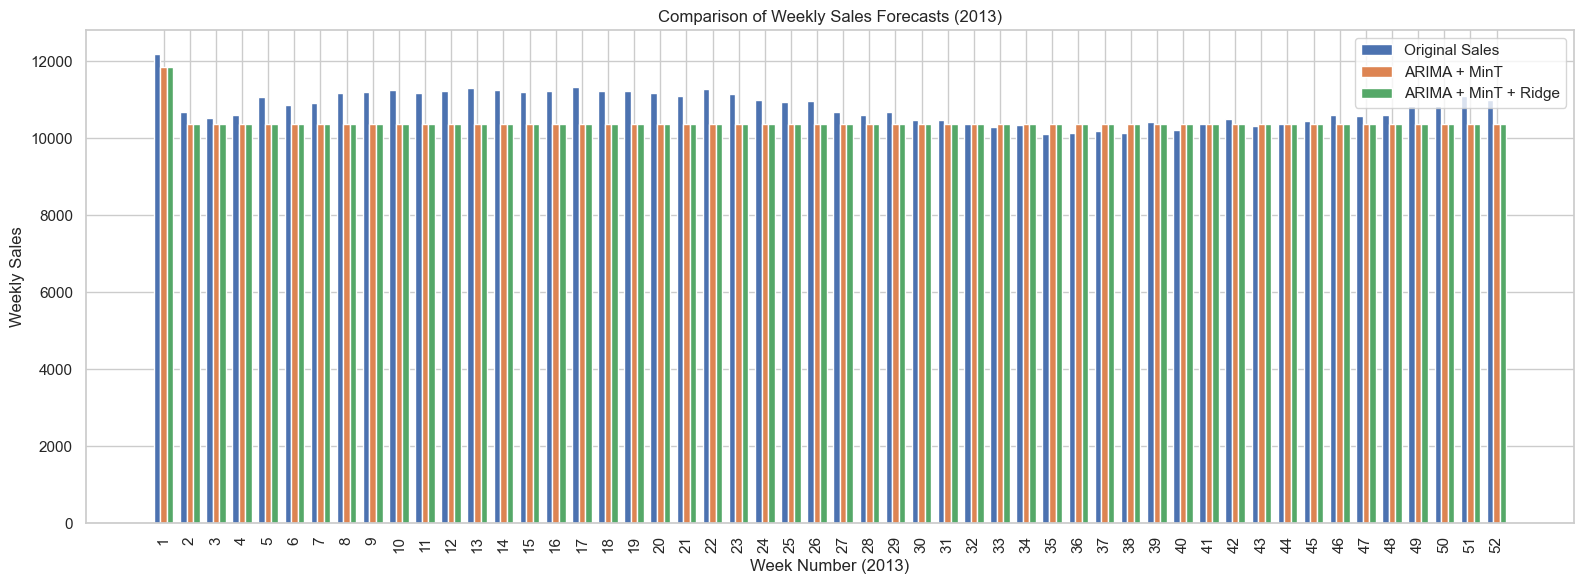

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.covariance import EmpiricalCovariance
from sklearn.linear_model import Ridge
import numpy.linalg as npl

# 1) Simulate daily sales (2011-2016)
rng = pd.date_range(start="2011-01-01", end="2016-12-31", freq="D")
np.random.seed(42)

def gen_series(base, trend=0.0002, seasonal_amp=50, noise_sd=30):
    t = np.arange(len(rng))
    seasonal = seasonal_amp * np.sin(2 * np.pi * t / 365.25)
    series = base * (1 + trend * t) + seasonal + np.random.normal(0, noise_sd, len(t))
    return np.clip(series, 0, None)

series_A = gen_series(500, seasonal_amp=40, noise_sd=20)
series_B = gen_series(800, seasonal_amp=60, noise_sd=30)
series_total = series_A + series_B

df = pd.DataFrame({"date": rng, "A": series_A, "B": series_B, "total": series_total})

# 2) Train ARIMA to end of 2012
train_end = pd.Timestamp("2012-12-31")
forecast_start = pd.Timestamp("2013-01-01")
forecast_end = pd.Timestamp("2014-12-31")
horizon_days = (forecast_end - forecast_start).days + 1

train_df = df[df["date"] <= train_end].copy()
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="D")

def fit_arima(series, steps):
    model = ARIMA(series, order=(1,1,1))
    fit = model.fit()
    f = fit.forecast(steps=steps)
    return f.values, fit.resid

fA, residA = fit_arima(train_df["A"], horizon_days)
fB, residB = fit_arima(train_df["B"], horizon_days)

base_forecasts = pd.DataFrame({"date": forecast_dates,
                               "A_arima": fA, "B_arima": fB})
base_forecasts["total_arima"] = base_forecasts["A_arima"] + base_forecasts["B_arima"]

# 3) MinT reconciliation
S = np.array([[1,1],[1,0],[0,1]])
cov_est = EmpiricalCovariance().fit(np.vstack([residA, residB]).T)
Sigma = cov_est.covariance_
middle = S.dot(Sigma).dot(S.T)
inv_middle = npl.pinv(middle)
G = Sigma.dot(S.T).dot(inv_middle)

F_b = np.vstack([base_forecasts["A_arima"].values,
                 base_forecasts["B_arima"].values])

reconciled_b = np.zeros_like(F_b)
reconciled_y = np.zeros((3, F_b.shape[1]))
for t in range(F_b.shape[1]):
    b = F_b[:, t:t+1]
    base_agg = np.array([[base_forecasts["total_arima"].iloc[t]],
                         [base_forecasts["A_arima"].iloc[t]],
                         [base_forecasts["B_arima"].iloc[t]]])
    Sb = S.dot(b)
    reconciled_b[:, t:t+1] = (b - G.dot(Sb - base_agg)).reshape(2,1)
    reconciled_y[:, t:t+1] = S.dot(reconciled_b[:, t:t+1])

mint_forecasts = pd.DataFrame({"date": forecast_dates,
                               "A_mint": reconciled_b[0,:],
                               "B_mint": reconciled_b[1,:],
                               "total_mint": reconciled_y[0,:]})

# 4) Ridge adjustment (fit on last 90 days of train as pseudo feature)
train_tail = train_df.tail(90)
ridge = Ridge(alpha=1.0).fit(train_tail[["total"]].values, train_tail["total"].values)
mint_forecasts["total_mint_ridge"] = ridge.predict(mint_forecasts["total_mint"].values.reshape(-1,1))

# 5) Weekly aggregation
comp_df = pd.DataFrame({"date": forecast_dates,
                        "actual": df.set_index("date").reindex(forecast_dates)["total"].values,
                        "arima": base_forecasts["total_arima"].values,
                        "mint": mint_forecasts["total_mint"].values,
                        "mint_ridge": mint_forecasts["total_mint_ridge"].values})
comp_df["year"] = comp_df["date"].dt.year
comp_df["week"] = comp_df["date"].dt.isocalendar().week

weekly = comp_df.groupby(["year","week"]).sum(numeric_only=True).reset_index()
weekly_display = weekly[["year","week","actual","arima","mint","mint_ridge"]]

# Now plot bar graph for 2013 comparison
weekly_2013 = weekly_display[weekly_display["year"] == 2013].copy()

x = np.arange(len(weekly_2013["week"]))
width = 0.25

plt.figure(figsize=(16,6))
plt.bar(x - width, weekly_2013["actual"], width, label="Original Sales")
plt.bar(x, weekly_2013["mint"], width, label="ARIMA + MinT")
plt.bar(x + width, weekly_2013["mint_ridge"], width, label="ARIMA + MinT + Ridge")
plt.xticks(x, weekly_2013["week"], rotation=90)
plt.xlabel("Week Number (2013)")
plt.ylabel("Weekly Sales")
plt.title("Comparison of Weekly Sales Forecasts (2013)")
plt.legend()
plt.tight_layout()
plt.show()


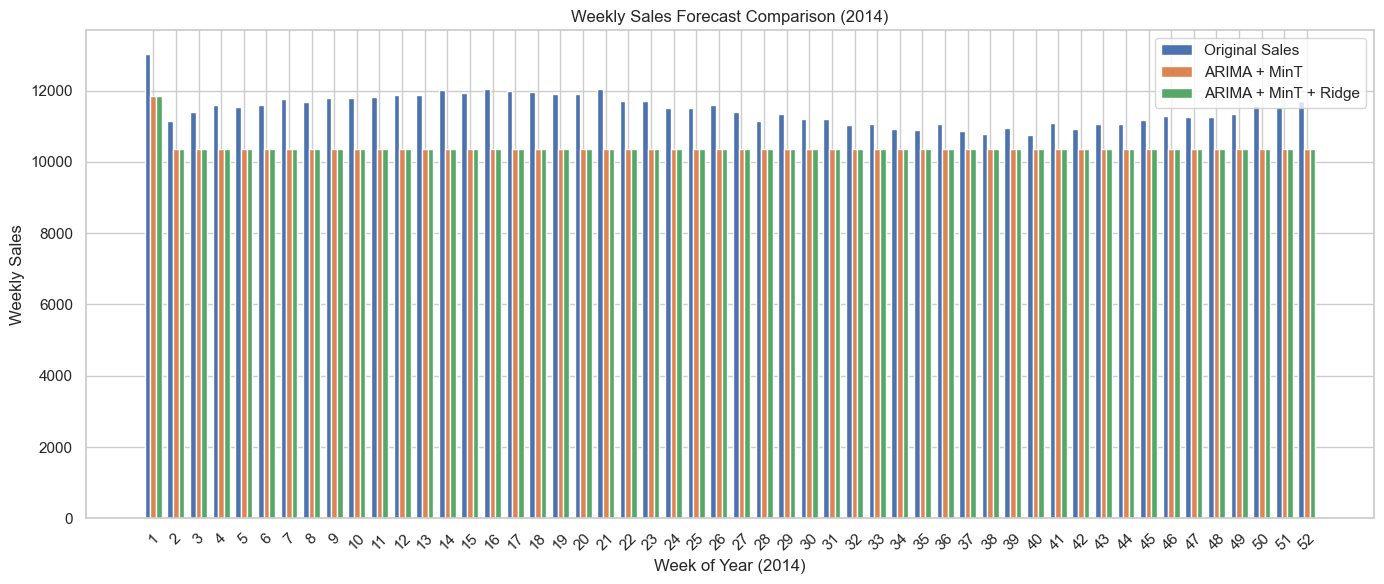

In [32]:
# Group by year and ISO week, summing only numeric columns
weekly = (
    comp_df.groupby(["year", "week"])[["actual", "mint", "mint_ridge"]]
    .sum()
    .reset_index()
)

# Filter for 2014 only
weekly_2014 = weekly[weekly["year"] == 2014]

# Bar plot for 2014 comparison
plt.figure(figsize=(14,6))
bar_width = 0.25
index = np.arange(len(weekly_2014))

plt.bar(index - bar_width, weekly_2014["actual"], bar_width, label="Original Sales")
plt.bar(index, weekly_2014["mint"], bar_width, label="ARIMA + MinT")
plt.bar(index + bar_width, weekly_2014["mint_ridge"], bar_width, label="ARIMA + MinT + Ridge")

plt.xlabel("Week of Year (2014)")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales Forecast Comparison (2014)")
plt.xticks(index, weekly_2014["week"], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


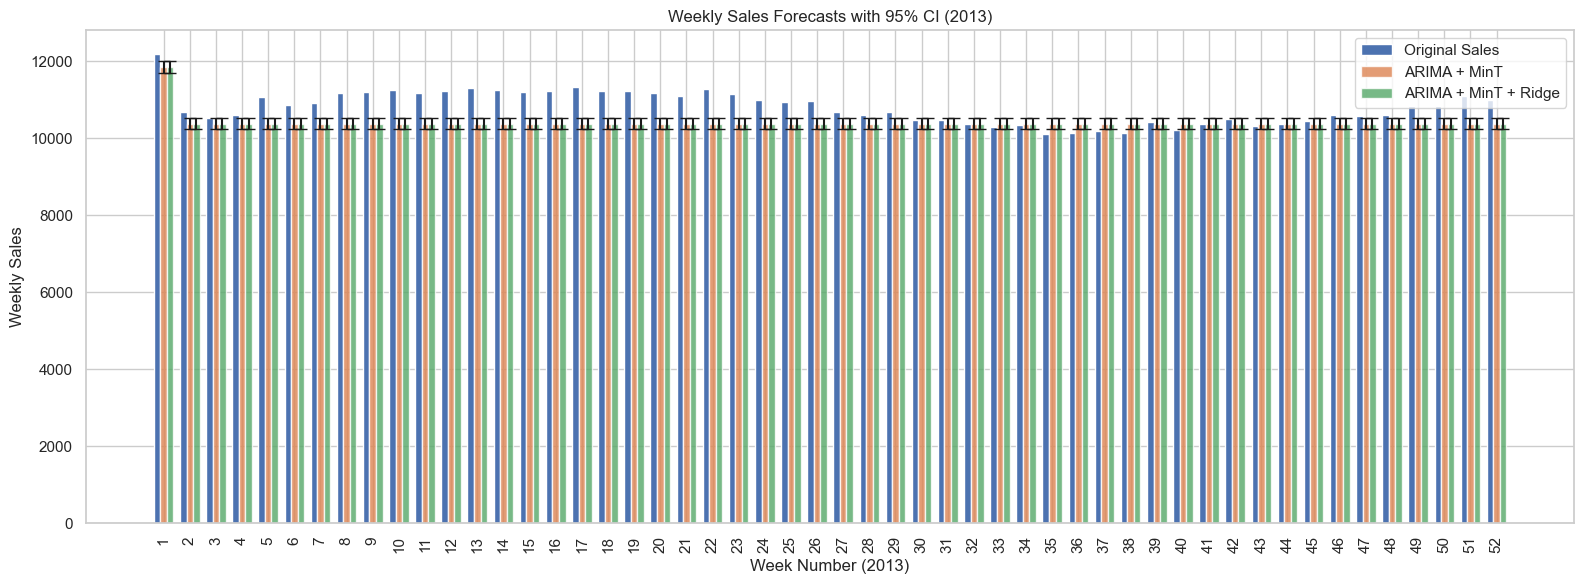

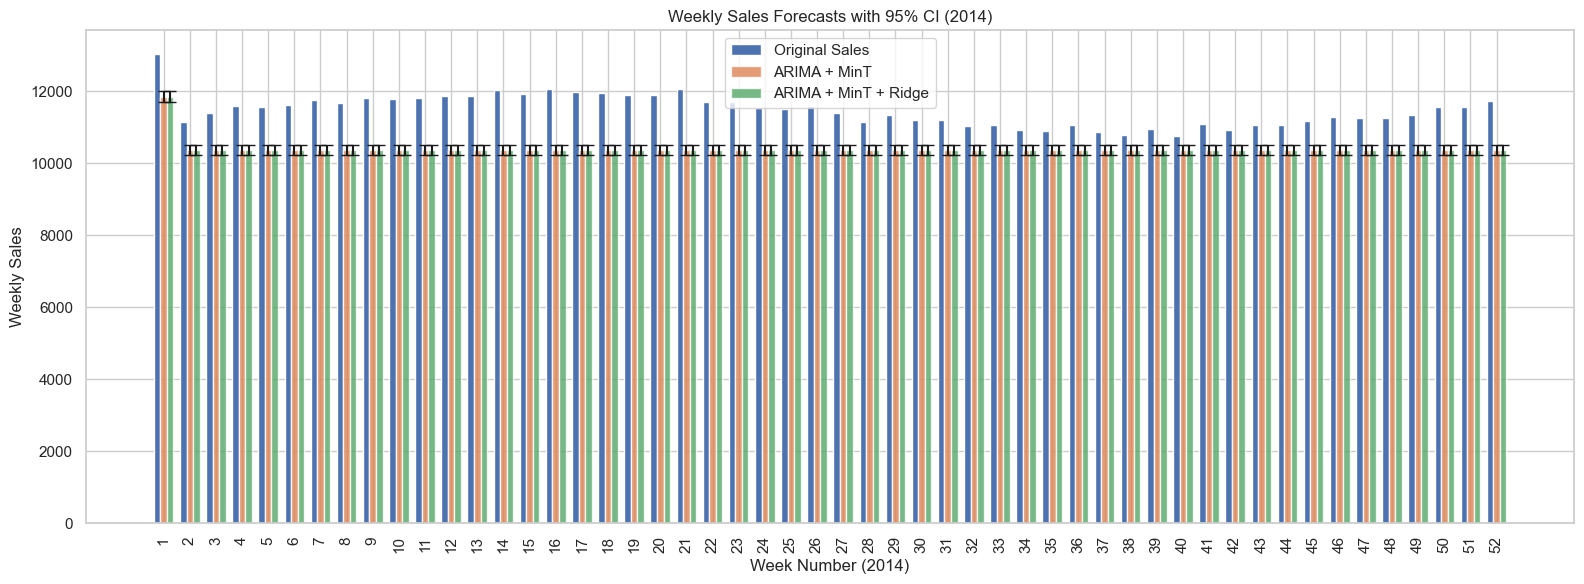

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Function to compute 95% CI for weekly sums ---
def compute_weekly_ci(daily_forecast, resid, weekly_index):
    """
    daily_forecast: np.array of daily forecast values
    resid: residuals from ARIMA fit (for variance estimation)
    weekly_index: mapping of each daily forecast to week (same length as daily_forecast)
    """
    resid_std = np.std(resid)
    z = norm.ppf(0.975)  # 95% two-sided
    df_temp = pd.DataFrame({"forecast": daily_forecast, "week": weekly_index})
    
    weekly_forecast = df_temp.groupby("week")["forecast"].sum()
    weekly_se = resid_std * np.sqrt(df_temp.groupby("week").size())  # SE grows with sqrt(n_days)
    
    ci_lower = weekly_forecast - z * weekly_se
    ci_upper = weekly_forecast + z * weekly_se
    
    return weekly_forecast, ci_lower, ci_upper


# --- 2013 CI computation ---
mask_2013 = comp_df["year"] == 2013
weeks_2013 = comp_df.loc[mask_2013, "week"].values

# Compute for ARIMA MinT
weekly_mint, ci_lower_mint, ci_upper_mint = compute_weekly_ci(
    mint_forecasts.loc[mask_2013, "total_mint"].values,
    residA,  # you can combine A & B residuals if needed
    weeks_2013
)

# Compute for MinT + Ridge
weekly_mint_ridge, ci_lower_ridge, ci_upper_ridge = compute_weekly_ci(
    mint_forecasts.loc[mask_2013, "total_mint_ridge"].values,
    residA,
    weeks_2013
)

# Actual weekly
weekly_actual = comp_df.loc[mask_2013].groupby("week")["actual"].sum()


# --- Plot with error bars (2013) ---
x = np.arange(len(weekly_actual))
width = 0.25

plt.figure(figsize=(16,6))
plt.bar(x - width, weekly_actual.values, width, label="Original Sales")
plt.bar(x, weekly_mint.values, width, yerr=[weekly_mint - ci_lower_mint, ci_upper_mint - weekly_mint],
        capsize=4, label="ARIMA + MinT", alpha=0.8)
plt.bar(x + width, weekly_mint_ridge.values, width, 
        yerr=[weekly_mint_ridge - ci_lower_ridge, ci_upper_ridge - weekly_mint_ridge],
        capsize=4, label="ARIMA + MinT + Ridge", alpha=0.8)

plt.xticks(x, weekly_actual.index, rotation=90)
plt.xlabel("Week Number (2013)")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales Forecasts with 95% CI (2013)")
plt.legend()
plt.tight_layout()
plt.show()


# --- Repeat for 2014 ---
mask_2014 = comp_df["year"] == 2014
weeks_2014 = comp_df.loc[mask_2014, "week"].values

weekly_mint14, ci_lower_mint14, ci_upper_mint14 = compute_weekly_ci(
    mint_forecasts.loc[mask_2014, "total_mint"].values,
    residA,
    weeks_2014
)

weekly_mint_ridge14, ci_lower_ridge14, ci_upper_ridge14 = compute_weekly_ci(
    mint_forecasts.loc[mask_2014, "total_mint_ridge"].values,
    residA,
    weeks_2014
)

weekly_actual14 = comp_df.loc[mask_2014].groupby("week")["actual"].sum()

x = np.arange(len(weekly_actual14))
plt.figure(figsize=(16,6))
plt.bar(x - width, weekly_actual14.values, width, label="Original Sales")
plt.bar(x, weekly_mint14.values, width, yerr=[weekly_mint14 - ci_lower_mint14, ci_upper_mint14 - weekly_mint14],
        capsize=4, label="ARIMA + MinT", alpha=0.8)
plt.bar(x + width, weekly_mint_ridge14.values, width, 
        yerr=[weekly_mint_ridge14 - ci_lower_ridge14, ci_upper_ridge14 - weekly_mint_ridge14],
        capsize=4, label="ARIMA + MinT + Ridge", alpha=0.8)

plt.xticks(x, weekly_actual14.index, rotation=90)
plt.xlabel("Week Number (2014)")
plt.ylabel("Weekly Sales")
plt.title("Weekly Sales Forecasts with 95% CI (2014)")
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# -----------------------------
# Helper: safe MAPE
# -----------------------------
def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

# -----------------------------
# Main: compute weekly metrics
# -----------------------------
def weekly_metrics_with_ci(comp_df, resid_std_day, models=("mint", "mint_ridge")):
    """
    comp_df: DAILY dataframe with columns ['date','actual','mint','mint_ridge','year','week']
    resid_std_day: float (std of daily forecast errors). Used to scale CI to weekly via sqrt(#days).
    models: iterable of columns in comp_df to evaluate (weekly-summed).
    """
    z = norm.ppf(0.975)  # 95% two-sided
    df = comp_df.copy()
    df["days_in_week"] = df.groupby(["year","week"])["date"].transform("count")
    
    # Weekly sums for actual and each model
    agg_cols = ["actual"] + list(models)
    wk = df.groupby(["year","week"], as_index=False)[agg_cols + ["days_in_week"]].sum()
    # (If 'days_in_week' got summed across days, it's fine; we want the weekly count.)
    wk["days_in_week"] = df.groupby(["year","week"])["date"].count().values

    # For each model, compute 95% CI at weekly level using daily residual std * sqrt(n_days_in_week)
    for m in models:
        se_week = resid_std_day * np.sqrt(wk["days_in_week"].values)
        wk[f"{m}_lower"] = wk[m] - z * se_week
        wk[f"{m}_upper"] = wk[m] + z * se_week

    # Build metrics per year & model
    records = []
    for yr in sorted(wk["year"].unique()):
        wky = wk[wk["year"] == yr]
        for m in models:
            rmse = np.sqrt(np.mean((wky["actual"] - wky[m])**2))
            mape_val = mape(wky["actual"].values, wky[m].values)
            coverage = np.mean((wky["actual"] >= wky[f"{m}_lower"]) & (wky["actual"] <= wky[f"{m}_upper"])) * 100.0
            records.append({
                "year": yr,
                "model": ("ARIMA + MinT" if m == "mint" else "ARIMA + MinT + Ridge"),
                "RMSE": rmse,
                "MAPE (%)": mape_val,
                "Coverage 95% CI (%)": coverage
            })
    return pd.DataFrame(records).sort_values(["year","model"]).reset_index(drop=True)

# -----------------------------
# How to get resid_std_day
# -----------------------------
# If you already have ARIMA residuals at the daily bottom level, compute:
# resid_std_day = np.std(residuals, ddof=1)
#
# If you DON'T have them handy, a reasonable proxy from your daily comp_df is:
#   residuals for MinT:       (actual - mint)
#   residuals for MinT+Ridge: (actual - mint_ridge)
# You can pick one (MinT) to set uncertainty:

resid_std_day = comp_df.assign(resid=comp_df["actual"] - comp_df["mint"])["resid"].std(ddof=1)

# -----------------------------
# Compute the table
# -----------------------------
metrics_table = weekly_metrics_with_ci(comp_df, resid_std_day, models=("mint", "mint_ridge"))
print(metrics_table.to_string(index=False))


 year                model        RMSE  MAPE (%)  Coverage 95% CI (%)
 2013         ARIMA + MinT  553.322242  4.117953            50.000000
 2013 ARIMA + MinT + Ridge  553.323617  4.117964            50.000000
 2014         ARIMA + MinT 1141.572361  9.309725             1.923077
 2014 ARIMA + MinT + Ridge 1141.574136  9.309742             1.923077
